In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/bert-finetuned"

sys.path.insert(0, ABSOLUTE_PATH)

# Training BERT Transformer

In [28]:
!pip install tensorboardX transformers --upgrade

In [29]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torch.optim import AdamW
from tqdm import tqdm

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

## Loading the model and tokenizer

In [30]:
MODEL_NAME = "bert-base-cased"
NUM_LABELS = 2
BATCH_SIZE = 8

EPOCHS = 10
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-5
EARLY_STOPPING = 3

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

## Loading the preprocessed data

In [32]:
# Import splits of the dataset (train, val, test)
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"))
)

train_df.rename(columns={'account.type': 'label'}, inplace=True)
val_df.rename(columns={'account.type': 'label'}, inplace=True)
test_df.rename(columns={'account.type': 'label'}, inplace=True)

# Extra processing for pytorch dataset
X_train = train_df['text'].values
y_train = (train_df['label'] == 'bot').astype(int).values

X_val = val_df['text'].values
y_val = (val_df['label'] == 'bot').astype(int).values

X_test = test_df['text'].values
y_test = (test_df['label'] == 'bot').astype(int).values

In [33]:
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

## Training the model

In [35]:
training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
    callbacks=[early_stopping],
)

<ipython-input-35-19f1bbf1a455>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.281800,0.316388,0.893136
2,0.233500,0.407373,0.881407
3,0.128700,0.625627,0.873588
4,0.062700,0.638694,0.888358


TrainOutput(global_step=10356, training_loss=0.1867719790612284, metrics={'train_runtime': 1875.3836, 'train_samples_per_second': 110.441, 'train_steps_per_second': 13.805, 'total_flos': 2.179822471446528e+16, 'train_loss': 0.1867719790612284, 'epoch': 4.0})

In [37]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.29778051376342773,
 'eval_accuracy': 0.8901485800743103,
 'eval_runtime': 9.0717,
 'eval_samples_per_second': 282.196,
 'eval_steps_per_second': 35.275,
 'epoch': 4.0}

In [38]:
test_results_df = pd.DataFrame.from_dict(test_results, orient="index", columns=["value"])
test_results_df.index.name = "metric"
test_results_df.reset_index(inplace=True)
test_results_df

,metric,value
0,eval_loss,0.297781
1,eval_accuracy,0.890149
2,eval_runtime,9.071700
3,eval_samples_per_second,282.196000
4,eval_steps_per_second,35.275000
5,epoch,4.000000


In [39]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [40]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1278
           1       0.87      0.92      0.89      1280

    accuracy                           0.89      2558
   macro avg       0.89      0.89      0.89      2558
weighted avg       0.89      0.89      0.89      2558



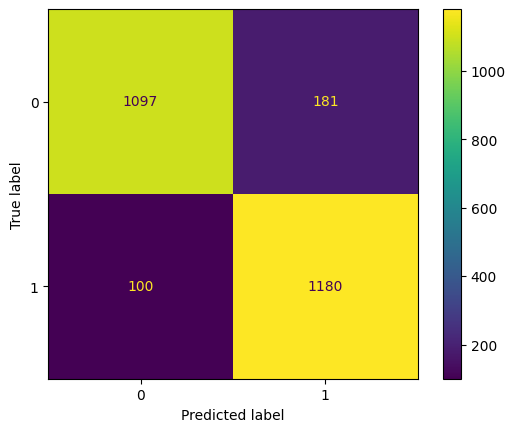

In [41]:
plot_confusion_matrix(y_test, predicted_labels)